In [40]:
import pandas as pd
import boto3
import awswrangler as wr
import numpy as np
from collections import Counter
import os
import random

import torch, torchtext
import torchvision.models as models
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader
from torchtext.vocab import GloVe
from torch import nn, optim

from tqdm import tqdm

SEED = 1234
N_SAMPLES = 10_000

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

import time

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
chunks = pd.read_csv('../data/toxic_data.csv', chunksize=100000)
df = pd.concat(chunks)
df.head()

,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,0,2,0,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental hospitals. Boorah,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,1,2,0,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by not making this announcement himself.\n\nWhat an awful human being .....,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,2,3,7,0.666667,0.015873,0.031746,0.000000,0.047619,0.666667,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,7084460,"""while arresting a man for resisting arrest"".\n\nIf you cop-suckers can't see a problem with this, then go suck the barrel of a Glock.",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,0,0,0,0.815789,0.065789,0.552632,0.592105,0.000000,0.684211,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,0,1,0,0.550000,0.037500,0.337500,0.275000,0.037500,0.487500,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80


In [10]:
df['comment_text'] = df['comment_text'].fillna("")
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
for col in identity_columns + ['toxicity']:
    df.loc[:, col] = np.where(df[col] >= 0.5, True, False)

In [11]:
train_df = df[df['split'] == 'train']
test_df = df[df['split'] != 'train']
train_df.shape, test_df.shape

((1804875, 46), (194641, 46))

In [12]:
sample = train_df.sample(N_SAMPLES, random_state=SEED, ignore_index=True)
train_text, val_text, train_label, val_label = train_test_split(sample['comment_text'], sample['toxicity'], test_size=0.2, random_state=SEED)
test_text, test_label = test_df['comment_text'], test_df['toxicity']

train_label = torch.tensor(train_label.values, dtype=torch.float32).to(device)
val_label = torch.tensor(val_label.values, dtype=torch.float32).to(device) 
test_label = torch.tensor(test_label.values, dtype=torch.float32).to(device) 

In [13]:
train_text.shape, test_text.shape, len(train_label), len(test_label), val_text.shape, len(val_label)

((8000,), (194641,), 8000, 194641, (2000,), 2000)

In [14]:
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for line in train_text:
    counter.update(tokenizer(line))
    
# Create a vocabulary with words seen at least 3 (min_freq) times
vocab = torchtext.vocab.vocab(counter, min_freq=3)

In [15]:
# Add the unknown token and use it by default for unknown words
unk_token = '<unk>'
# vocab.insert_token(unk_token, 0)
vocab.set_default_index(0)

# Add the pad token Explanation https://huggingface.co/docs/transformers/pad_truncation
pad_token = '<pad>'
vocab.insert_token(pad_token, 1)

In [16]:
text_transform_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

In [17]:
print(f"Before transform:\n{train_text.iloc[1666]}")
print(f"After transform:\n{text_transform_pipeline(train_text.iloc[1666])}")

Before transform:
Putin will invite Trump and Bibi to Crimea (Yalta) to divide the world. Just like they did in February 1945. King wasnt invited because he was anti-communist and many believed anti-semite. This time Justin will be invited for the entertainment value. During the evening time he can sing and dance along the Black Sea shores. Justin will extol the virtues of diversity and having a good hairdresser to prevent split ends.
After transform:
[2558, 229, 3899, 289, 43, 0, 12, 7302, 185, 0, 190, 12, 3614, 5, 259, 28, 39, 752, 134, 254, 45, 7148, 0, 28, 4787, 0, 5324, 155, 354, 62, 0, 43, 228, 3916, 0, 28, 93, 129, 3401, 229, 65, 5324, 0, 5, 5775, 2977, 28, 908, 5, 7303, 129, 354, 140, 4372, 43, 6380, 976, 5, 910, 707, 6201, 28, 3401, 229, 0, 5, 7304, 21, 815, 43, 2078, 17, 205, 0, 12, 1881, 6284, 5503, 28]


In [18]:
def transformText(text_list, max_len):
    # Transform the text
    transformed_data = [text_transform_pipeline(text)[:max_len] for text in text_list]

    # Pad zeros if the text is shoter than max_len
    for data in transformed_data:
        data[len(data) : max_len] = np.ones(max_len - len(data))

    return torch.tensor(transformed_data, dtype=torch.int64)

In [19]:
max_len = 100
batch_size = 64

# Pass transformed and padded data to dataset
# Create data loaders
train_dataset = TensorDataset(
    transformText(train_text, max_len), train_label
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(transformText(val_text, max_len), val_label)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(transformText(test_text, max_len), test_label)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/tmp/ipykernel_96/3562846554.py:9: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(transformed_data, dtype=torch.int64)


In [20]:
#Pretrained Word Embeddings ====> GloVe, FastText, CharNGram

glove = GloVe(name="6B", dim=300)
embedding_matrix = glove.get_vecs_by_tokens(vocab.get_itos())

In [22]:
embedding_matrix.shape

torch.Size([9864, 300])

In [25]:
# Size of the state vectors
hidden_size = 12
# General NN training parameters
learning_rate = 0.005
epochs = 5

# Embedding vector and vocabulary sizes
embed_size = 300  # glove.6B.300d.txt
vocab_size = len(vocab.get_itos())
vocab_size

9864

In [26]:
class Net(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(
            embed_size, hidden_size, num_layers=num_layers
        )

        self.linear = nn.Linear(hidden_size*max_len, 1)
        self.act = nn.Sigmoid()

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        # Call RNN layer
        outputs, _ = self.rnn(embeddings)
        # Use the output of each time step
        # Send it all together to the linear layer
        outs = self.linear(outputs.reshape(outputs.shape[0], -1))
        return self.act(outs)
    
model = Net(vocab_size, embed_size, hidden_size, num_layers=2)

# Initialize the weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.RNN:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
                
# We set the embedding layer's parameters from GloVe
model.embedding.weight.data.copy_(embedding_matrix)
# We won't change/train the embedding layer
# model.embedding.weight.requires_grad = False


In [27]:
# Setting our trainer
trainer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# We will use Binary Cross-entropy loss
# reduction="sum" sums the losses for given output and target
cross_ent_loss = nn.BCELoss(reduction="sum")

In [33]:
train_losses = []
val_losses = []

# Get the compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.apply(init_weights)
model.to(device)

for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    val_loss = 0
    # Training loop, train the network
    for data, target in train_loader:
        trainer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        L = cross_ent_loss(output.squeeze(1), target)
        training_loss += L.item()
        L.backward()
        trainer.step()

    # Validate the network, no training (no weight update)
    for data, target in val_loader:
        val_predictions = model(data.to(device))
        L = cross_ent_loss(val_predictions.squeeze(1), target.to(device))
        val_loss += L.item()

    # Let's take the average losses
    training_loss = training_loss / len(train_label)
    val_loss = val_loss / len(val_label)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss}. Validation_loss {val_loss}. Seconds {end-start}"
    )

Epoch 0. Train_loss 0.3096252073645592. Validation_loss 0.31215855741500853. Seconds 2.619668483734131
Epoch 1. Train_loss 0.24661477690935135. Validation_loss 0.3291655163764954. Seconds 2.5538554191589355
Epoch 2. Train_loss 0.20887392330169677. Validation_loss 0.35711542224884035. Seconds 2.479990243911743
Epoch 3. Train_loss 0.18000820028781891. Validation_loss 0.38597973585128786. Seconds 2.6384105682373047
Epoch 4. Train_loss 0.16153031063079834. Validation_loss 0.40599333572387697. Seconds 2.5510659217834473


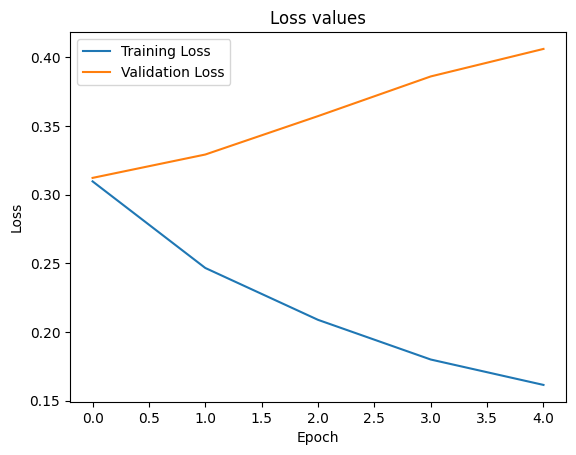

In [34]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [35]:
test_predictions = []
for data, target in tqdm(test_loader):
    test_preds = model(data.to(device))
    test_predictions.extend(
        [np.rint(test_pred)[0] for test_pred in test_preds.detach().cpu().numpy()]
    )

100%|██████████| 3042/3042 [00:22<00:00, 136.36it/s]


In [36]:
sum(test_predictions), len(test_predictions)

(9956.0, 194641)

In [37]:
oof_name = 'predicted_target'
test_df[oof_name] = test_predictions

In [38]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, oof_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[oof_name])

def compute_bpsn_auc(df, subgroup, label, oof_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[oof_name])

def compute_bnsp_auc(df, subgroup, label, oof_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[oof_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)
bias_metrics_df = compute_bias_metrics_for_model(test_df, identity_columns, oof_name, 'toxicity')
bias_metrics_df

/tmp/ipykernel_96/3689227233.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
/tmp/ipykernel_96/3689227233.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
/tmp/ipykernel_96/3689227233.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
/tmp/ipykernel_96/3689227233.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
/tmp/ipy

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,1065,0.503737,0.508259,0.513847
8,psychiatric_or_mental_illness,511,0.512602,0.507767,0.523066
1,female,5155,0.513031,0.509731,0.521606
4,jewish,835,0.513422,0.504990,0.526648
5,muslim,2040,0.514006,0.511791,0.520442
6,black,1519,0.523834,0.493649,0.547578
0,male,4386,0.527030,0.505790,0.538803
7,white,2452,0.527429,0.493363,0.550894
3,christian,4226,0.529261,0.518583,0.528616


In [39]:
def calculate_overall_auc(df, oof_name):
    true_labels = df['toxicity']
    predicted_labels = df[oof_name]
    return roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
FINAL_SCORE = get_final_metric(bias_metrics_df, calculate_overall_auc(test_df, oof_name))
print(f"FINAL SCORE IS {FINAL_SCORE}")

FINAL SCORE IS 0.5177764236521629
